In [1]:
#cells_meta_f = ""
# Input info
indir = "/data/Mito_Trace/output/pipeline/v02/CHIP_b1/MTBlacklist_A2/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/clonal_shifts/variants_init/donors/donor0/clones/knn_kparam_30/"
#noInput_indir = "/data/Mito_Trace/output/pipeline/v02/CHIP_b1/MTBlacklist_A2/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/clonal_shifts/variants_init/clones/results/noInput/knn/kparam_30/"
#input_indir = "/data/Mito_Trace/output/pipeline/v02/CHIP_b1/MTBlacklist_A2/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/clonal_shifts/variants_init/clones/results/inputOnly/knn/kparam_30/"
outdir = "/data/Mito_Trace/output/pipeline/v02/CHIP_b1/MTBlacklist_A2/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/clonal_shifts/donors/donor0/variants_init/knn/kparam_30/clones/"

# params
p_thresh = 0.1 


#cloneID = ""


In [2]:

from glob import glob
import pandas as pd
import numpy as np
from os.path import join, exists
import os
from tqdm.notebook import tqdm

from scipy.stats import hypergeom, fisher_exact
from statsmodels.stats import multitest 

import seaborn as sns
import matplotlib.pyplot as plt

from src import clonal_shifts as cs
from icecream import ic

from mplh import cluster_help as ch

from scipy.stats import rankdata, gmean


fig_utils from mplh


In [3]:
#cells_meta = pd.read_csv(cells_meta_f, sep="\t")

In [4]:
noInput_hyper = pd.read_csv(join(indir, "noInput_hypergeo_pvals.csv"),  index_col=0)
noInput_shuffle_df = pd.read_csv(join(indir, "noInput_shuffle_results_pvals.csv"), index_col=0)
noInput_shuffle_df = noInput_shuffle_df.rename({"value":"pval"}, axis=1)

input_hyper = pd.read_csv(join(indir, "input_hypergeo_pvals.csv"), index_col=0)
input_shuffle_df = pd.read_csv(join(indir, "input_shuffle_results_pvals.csv"), index_col=0)

input_shuffle_df = input_shuffle_df.rename({"value":"pval"}, axis=1)
input_shuffle_df

input_hyper_df = input_hyper.reset_index().melt(id_vars="index", value_name="pval")
input_hyper_df["method"] = "hypergeo"
noInput_hyper_df = noInput_hyper.reset_index().melt(id_vars="index", value_name="pval")
noInput_hyper_df["method"] = "hypergeo"



noInput_hyper_df["condition"] = "cultured"
noInput_shuffle_df["condition"] = "cultured"
input_hyper_df["condition"] = "input"
input_shuffle_df["condition"] = "input"


In [5]:
input_df = pd.concat((input_hyper_df, input_shuffle_df), axis=0, ignore_index=True)
input_df

,index,variable,pval,method,condition
0,0_0,CLP,1.0,hypergeo,input
1,0_1,CLP,1.0,hypergeo,input
2,0_10,CLP,1.0,hypergeo,input
3,0_11,CLP,1.0,hypergeo,input
4,0_12,CLP,1.0,hypergeo,input
...,...,...,...,...,...
2375,0_5,neutrophil B,1.0,clone_min,input
2376,0_6,neutrophil B,1.0,clone_min,input
2377,0_7,neutrophil B,1.0,clone_min,input
2378,0_8,neutrophil B,1.0,clone_min,input


In [6]:
noInput_df = pd.concat((noInput_hyper_df, noInput_shuffle_df), axis=0, ignore_index=True)
noInput_df

,index,variable,pval,method,condition
0,0_0,CLP,1.0,hypergeo,cultured
1,0_1,CLP,1.0,hypergeo,cultured
2,0_10,CLP,1.0,hypergeo,cultured
3,0_11,CLP,1.0,hypergeo,cultured
4,0_12,CLP,1.0,hypergeo,cultured
...,...,...,...,...,...
2035,0_5,neutrophil B,1.0,clone_min,cultured
2036,0_6,neutrophil B,1.0,clone_min,cultured
2037,0_7,neutrophil B,1.0,clone_min,cultured
2038,0_8,neutrophil B,1.0,clone_min,cultured


In [7]:
df = pd.concat((input_df, noInput_df), axis=0).reset_index(drop=True)
#df = pd.merge(input_df, noInput_df, on=["index", "variable", "method"], suffixes=["_input", "_cultured"])
df

,index,variable,pval,method,condition
0,0_0,CLP,1.0,hypergeo,input
1,0_1,CLP,1.0,hypergeo,input
2,0_10,CLP,1.0,hypergeo,input
3,0_11,CLP,1.0,hypergeo,input
4,0_12,CLP,1.0,hypergeo,input
...,...,...,...,...,...
4415,0_5,neutrophil B,1.0,clone_min,cultured
4416,0_6,neutrophil B,1.0,clone_min,cultured
4417,0_7,neutrophil B,1.0,clone_min,cultured
4418,0_8,neutrophil B,1.0,clone_min,cultured


In [8]:
min_df = df.groupby(["index", "method", "condition"]).min()["pval"].reset_index()
min_df

,index,method,condition,pval
0,0_0,clone_all,cultured,0.137583
1,0_0,clone_all,input,0.006929
2,0_0,clone_min,cultured,0.892000
3,0_0,clone_min,input,0.085000
4,0_0,global_all,cultured,0.299498
...,...,...,...,...
335,0_9,global_all,input,0.301666
336,0_9,global_min,cultured,1.000000
337,0_9,global_min,input,1.000000
338,0_9,hypergeo,cultured,1.000000


In [9]:
min_df_wide = min_df.pivot(index="index", values="pval", columns=["method", "condition"])
min_df_wide.columns = ['_'.join(col).strip() for col in min_df_wide.columns.values] # flatten to 1D columns
min_df_wide

,clone_all_cultured,clone_all_input,clone_min_cultured,clone_min_input,global_all_cultured,global_all_input,global_min_cultured,global_min_input,hypergeo_cultured,hypergeo_input
index,,,,,,,,,,
0_0,0.137583,0.006929,0.892,0.085,0.299498,0.008739,1.0,0.988,1.000000,1.000000
0_1,0.008083,0.062857,0.097,0.604,0.014765,0.134952,1.0,1.000,1.000000,1.000000
0_10,0.007000,0.022429,0.084,0.278,0.007350,0.019017,1.0,1.000,1.000000,1.000000
0_11,0.048167,0.120500,0.494,0.904,0.105718,0.210971,1.0,1.000,1.000000,1.000000
0_12,0.048167,0.086143,0.482,0.796,0.111091,0.115964,1.0,1.000,1.000000,1.000000
0_13,0.002000,0.031000,0.024,0.398,0.005610,0.011773,1.0,1.000,0.085047,1.000000
0_14,0.010000,0.003500,0.120,0.037,0.002451,0.007347,1.0,0.976,0.000009,1.000000
0_15,0.019167,0.014643,0.218,0.181,0.017272,0.023170,1.0,1.000,1.000000,1.000000
0_16,0.041167,0.000000,0.422,0.000,0.096125,0.000303,1.0,0.132,1.000000,0.004959


## Get the rank of each column (method) and then the geometric mean for each row (clone)

In [10]:
rank_df = min_df_wide.apply(lambda x: rankdata(x, method='max'), axis=0)
rank_df

,clone_all_cultured,clone_all_input,clone_min_cultured,clone_min_input,global_all_cultured,global_all_input,global_min_cultured,global_min_input,hypergeo_cultured,hypergeo_input
index,,,,,,,,,,
0_0,34,6,34,6,34,6,34,6,34,34
0_1,6,23,6,23,8,28,34,34,34,34
0_10,4,15,4,14,6,9,34,34,34,34
0_11,32,32,32,32,31,32,34,34,34,34
0_12,32,27,31,28,32,26,34,34,34,34
0_13,3,20,3,20,4,7,34,34,5,34
0_14,7,4,7,4,3,5,34,5,2,34
0_15,12,7,13,8,9,11,34,34,34,34
0_16,27,2,29,2,29,1,34,1,34,1


In [11]:
gmean_ser = rank_df.apply(gmean, axis=1)
gmean_ser = gmean_ser.sort_values()
gmean_ser



index
0_20     5.849323
0_18     6.334612
0_16     6.340416
0_14     6.506336
0_7      8.677079
0_4      9.845765
0_24     9.857098
0_13    10.707467
0_10    13.755135
0_15    16.080011
0_0     16.988219
0_27    17.335835
0_31    18.104715
0_1     18.862193
0_29    19.605659
0_23    20.712461
0_33    21.424857
0_3     21.689036
0_32    22.833591
0_26    23.531051
0_5     24.439292
0_19    24.457938
0_25    24.730882
0_8     24.810011
0_22    25.099277
0_17    25.951416
0_28    26.249926
0_30    26.374570
0_2     27.427202
0_6     28.248135
0_21    29.348746
0_12    31.053263
0_11    32.681556
0_9     33.696859
dtype: float64

## Get the clone order based on the mean of the rankings

In [12]:
clone_order = gmean_ser.index.values

min_df_wide = min_df_wide.loc[clone_order]
rank_df = rank_df.loc[clone_order]

In [13]:
clone_meta = pd.DataFrame(index=min_df_wide.columns, columns = ["condition"])
clone_meta["condition"] = ["input" if "input" in x else "cultured" for x in clone_meta.index]
clone_meta

,condition
clone_all_cultured,cultured
clone_all_input,input
clone_min_cultured,cultured
clone_min_input,input
global_all_cultured,cultured
global_all_input,input
global_min_cultured,cultured
global_min_input,input
hypergeo_cultured,cultured
hypergeo_input,input


## Plot rankings ordered by clone, annd save output

## Save:
a) cloneID_rank.png  
b) cloneID_order.txt - line-delimited text file with cloneID on each line  
c) cloneID_rank.csv  - csv file of the ranking for each category  
d) all_pvals: all p-values for for each clone-method-cluster-condition

FileNotFoundError: [Errno 2] No such file or directory: '/data/Mito_Trace/output/pipeline/v02/CHIP_b1/MTBlacklist_A2/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/clonal_shifts/donors/donor0/variants_init/knn/kparam_30/clones/cloneID_rank.png'

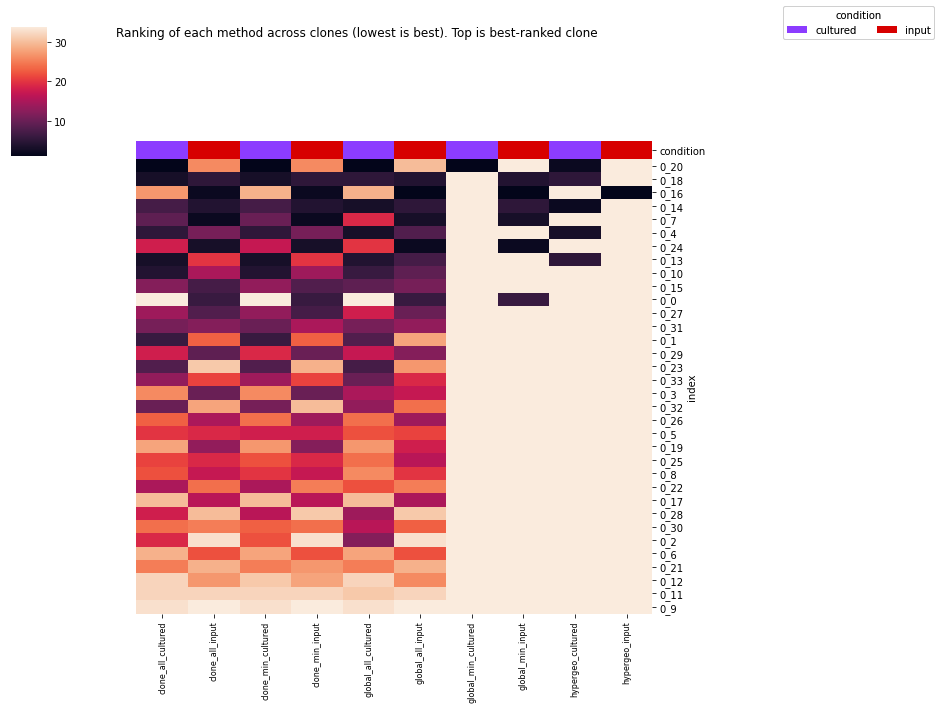

In [14]:
g = ch.plot_cluster(rank_df, to_row_clust=False, to_col_clust=False, col_meta=clone_meta[["condition"]])
g.fig.suptitle("Ranking of each method across clones (lowest is best). Top is best-ranked clone")
plt.savefig(join(outdir, "cloneID_rank.png"))

In [ ]:
rank_df.to_csv(join(outdir, "cloneID_rank.csv"))

In [ ]:
with open(join(outdir, "cloneID_order.txt"), "w") as f:
    f.write("\n".join(clone_order))
#np.savetxt(join(outdir, "cloneID_order.txt"), clone_order, delimiter="\n")

In [ ]:
df.to_csv(join(outdir, "all_pvals.csv"))